In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

from continualai.colab.scripts import mnist
mnist.init()

Cloning into 'continualai/colab'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 378 (delta 78), reused 64 (delta 62), pack-reused 258
Receiving objects: 100% (378/378), 26.97 MiB | 28.09 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Download complete.
Save complete.


100%|██████████| 9912422/9912422 [00:00<00:00, 35392198.65it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1208637.50it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9477744.76it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1175160.62it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [ ]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


(array([[-0.5, -0.5],
        [-0.5, -0.5]]),
 array([[27.5, 27.5],
        [27.5, 27.5]]),
 array([[27.5, 27.5],
        [27.5, 27.5]]),
 array([[-0.5, -0.5],
        [-0.5, -0.5]]))

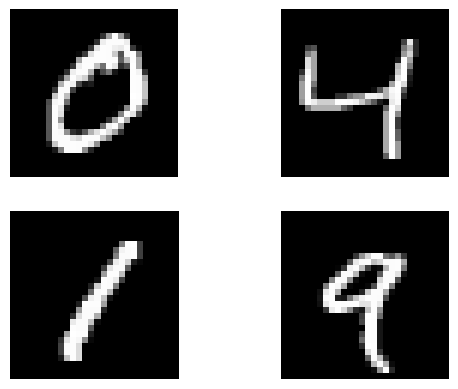

In [ ]:

f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(x_train[1, 0], cmap="gray")
axarr[0, 1].imshow(x_train[2, 0], cmap="gray")
axarr[1, 0].imshow(x_train[3, 0], cmap="gray")
axarr[1, 1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax: ax.axis('off'))(axarr)

In [ ]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)

In [ ]:
# Creating three tasks, task_1, task_2, and task_3, using the original MNIST dataset and permuted versions of the dataset.
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """
    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for dataset in mnist:
        num_img = dataset.shape[0]
        flat_set = dataset.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist


# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
def train_EWC(model, device, x_train, t_train, optimizer, epoch, ewc_lambda, fisher):
    model.train()

    for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)

        loss.backward()  # Compute gradients

        # Calculate EWC regularization term
        ewc_regularization = 0.0
        for name, param in model.named_parameters():
            if name in fisher:
                fisher[name] += torch.square(param.grad)
                ewc_regularization += (ewc_lambda * fisher[name] * (param - param.detach()) ** 2).sum()

        # Add EWC regularization term to the loss
        loss += ewc_regularization

        optimizer.step()

    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))



def test_EWC(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for start in range(0, len(t_test)-1, 256):
            end = start + 256
            x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
            x, y = x.to(device), y.to(device)
            output = model(x)
            test_loss += F.cross_entropy(output, y).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max logit
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# shuffle multiple lists (datasets) simultaneously
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

In [ ]:
offline_accs = []

# Store the Fisher information matrix for each parameter
fisher = {}
for name, param in model.named_parameters():
    fisher[name] = torch.zeros_like(param)

ewc_lambda = 0.01  # EWC regularization factor

print("Training on all tasks together...")
avg_acc = 0
(x_train, t_train), _ = tasks[0]

for i in range(1, len(tasks)):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))

x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

for epoch in range(1, 4):
    train_EWC(model, device, x_train, t_train, optimizer, epoch, ewc_lambda, fisher)

for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test_EWC(model, device, x_test, t_test)
    avg_acc = avg_acc + acc

print("Avg acc: ", avg_acc / 3)
for i in range(len(tasks)):
    offline_accs.append(avg_acc/3)

Training on all tasks together...
Train Epoch: 1 	Loss: 1.346628
Train Epoch: 2 	Loss: 0.810519
Train Epoch: 3 	Loss: 0.831743
Testing on task:  0
Test set: Average loss: 0.0007, Accuracy: 9440/10000 (94%)

Testing on task:  1
Test set: Average loss: 0.0017, Accuracy: 8792/10000 (88%)

Testing on task:  2
Test set: Average loss: 0.0018, Accuracy: 8729/10000 (87%)

Avg acc:  89.87
